<a href="https://www.kaggle.com/tunguz/tps-dec-2021-visualization-with-t-sne?scriptVersionId=82611949" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import gc
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/train.csv')


In [3]:
train.drop(columns=['Soil_Type7', 'Soil_Type15', 'Soil_Type1', 'Id'], inplace=True) 

In [4]:
new_names = {
    "Horizontal_Distance_To_Hydrology": "x_dist_hydrlgy",
    "Vertical_Distance_To_Hydrology": "y_dist_hydrlgy",
    "Horizontal_Distance_To_Roadways": "x_dist_rdwys",
    "Horizontal_Distance_To_Fire_Points": "x_dist_firepts"
}

train.rename(new_names, axis=1, inplace=True)

train["Aspect"][train["Aspect"] < 0] += 360

# Manhhattan distance to Hydrology
train["mnhttn_dist_hydrlgy"] = np.abs(train["x_dist_hydrlgy"]) + np.abs(train["y_dist_hydrlgy"])

# Euclidean distance to Hydrology
train["ecldn_dist_hydrlgy"] = (train["x_dist_hydrlgy"]**2 + train["y_dist_hydrlgy"]**2)**0.5

train.loc[train["Hillshade_9am"] < 0, "Hillshade_9am"] = 0

train.loc[train["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0

train.loc[train["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

train.loc[train["Hillshade_9am"] > 255, "Hillshade_9am"] = 255

train.loc[train["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255

train.loc[train["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

features_Hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
soil_features = [x for x in train.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in train.columns if x.startswith("Wilderness_Area")]

def addFeature(X):
    # Thanks @mpwolke : https://www.kaggle.com/mpwolke/tooezy-where-are-you-no-camping-here
    X["Soil_Count"] = X[soil_features].apply(sum, axis=1)

    # Thanks @yannbarthelemy : https://www.kaggle.com/yannbarthelemy/tps-december-first-simple-feature-engineering
    X["Wilderness_Area_Count"] = X[wilderness_features].apply(sum, axis=1)
    X["Hillshade_mean"] = X[features_Hillshade].mean(axis=1)
    X['amp_Hillshade'] = X[features_Hillshade].max(axis=1) - X[features_Hillshade].min(axis=1)
    
addFeature(train)

cols = [
    "Elevation",
    "Aspect",
    "mnhttn_dist_hydrlgy",
    "ecldn_dist_hydrlgy",
    "Slope",
    "x_dist_hydrlgy",
    "y_dist_hydrlgy",
    "x_dist_rdwys",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "x_dist_firepts",
    
    "Soil_Count","Wilderness_Area_Count","Hillshade_mean","amp_Hillshade"
]

scaler = RobustScaler()
train[cols] = scaler.fit_transform(train[cols])


train = train[train.Cover_Type !=5]

def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

train = reduce_mem_usage(train)


Mem. usage decreased to 434.88 Mb (75.8% reduction)


In [5]:
target = train[['Cover_Type']].values
train.drop(['Cover_Type'], axis=1, inplace=True)

In [6]:
train = train.values

In [7]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(train)

[W] [17:45:59.047279] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 6min 45s, sys: 4min 11s, total: 10min 57s
Wall time: 10min 59s


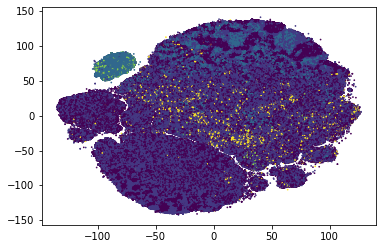

In [8]:
plt.scatter(train_2D[:,0], train_2D[:,1], c = target, s = 0.5)

In [9]:
1

1